In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
#Metrics
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import log_loss
from sklearn.metrics import zero_one_loss
from sklearn.metrics import matthews_corrcoef
from yellowbrick.classifier import ROCAUC
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay

#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam


##Lectura y preparación de la base de datos

In [ ]:
data= pd.read_excel('/content/database_non-shows (2) (3).xlsx')

In [ ]:
data['Appointment Type'].value_counts()

,count
Appointment Type,
1,12153
0,6434


In [ ]:
Labels = data['Appointment Type'].values
Features = data.drop(['Appointment Type'],axis=1).values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Features, Labels, test_size=0.2, stratify=Labels, random_state=42)

print('Train data shape:', X_train.shape)
print('Train labels shape:', y_train.shape)
print('Test data shape:', X_test.shape)
print('Test labels shape:', y_test.shape)

Train data shape: (14869, 12)
Train labels shape: (14869,)
Test data shape: (3718, 12)
Test labels shape: (3718,)


# Conversión a categorica

In [ ]:
y_train= tf.keras.utils.to_categorical(
    y_train, num_classes=2
)

In [ ]:
y_test= tf.keras.utils.to_categorical(
    y_test, num_classes=2
)

#Normalización

In [ ]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
X_train.shape

(14869, 12)

##Ajuste de forma de entrada

In [ ]:
X_train=np.expand_dims(X_train, axis=-1)
X_test=np.expand_dims(X_test, axis=-1)

In [ ]:
X_train.shape

(14869, 12, 1)

##Métricas

In [ ]:
def evaluate_model(model, X_test, y_test, history):

    # Realizar predicciones con el modelo
    y_pred = model.predict(X_test)

    # Obtener la clase con la máxima probabilidad en las etiquetas verdaderas (y_test)
    max_prob_true = np.argmax(y_test, axis=1)

    # Obtener la clase con la máxima probabilidad en las predicciones (predict)
    max_prob_pred = np.argmax(y_pred, axis=1)

    # Calcular las métricas
    accuracy = accuracy_score(max_prob_true, max_prob_pred)
    f1 = f1_score(max_prob_true, max_prob_pred)
    recall = recall_score(max_prob_true, max_prob_pred)

    # Mostrar las métricas
    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print("Recall:", recall)

    # Graficar la precisión para entrenamiento y validación
    plt.plot(history.history['accuracy'], label='Train Accuracy')  # Precisión del entrenamiento
    plt.plot(history.history['val_accuracy'], label='Test Accuracy')  # Precisión de la validación
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

    # Graficar la pérdida para entrenamiento y validación
    plt.plot(history.history['loss'], label='Train Loss')  # Pérdida del entrenamiento
    plt.plot(history.history['val_loss'], label='Test Loss')  # Pérdida de la validación
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

    # Calcular la matriz de confusión
    conf_matrix = confusion_matrix(max_prob_true, max_prob_pred)

    # Graficar la matriz de confusión usando seaborn
    plt.figure(figsize=(8,6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title('Confusion Matrix')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

     # Binarizar las etiquetas verdaderas para ROC multi-clase
    y_test_bin = label_binarize(y_test, classes=np.arange(y_pred.shape[1]))

    # Número de clases
    n_classes = y_pred.shape[1]

    # Inicializar las variables para la curva ROC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Calcular fpr, tpr y AUC para cada clase
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Gráfica ROC para cada clase
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    # Agregar la línea de referencia
    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')

    # Etiquetas y título del gráfico
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

##Red 1: ANN Simple- Relu

In [ ]:
model = Sequential()
model.add(Dense(16, input_dim=12, activation="relu"))
model.add(Dense(12, activation="relu"))
model.add(Dense(2, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = model.fit(X_train, y_train, epochs=250, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6305 - loss: 0.6616 - val_accuracy: 0.6931 - val_loss: 0.6039
Epoch 2/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6887 - loss: 0.5937 - val_accuracy: 0.7087 - val_loss: 0.5791
Epoch 3/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7071 - loss: 0.5677 - val_accuracy: 0.7179 - val_loss: 0.5626
Epoch 4/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7210 - loss: 0.5520 - val_accuracy: 0.7310 - val_loss: 0.5466
Epoch 5/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7257 - loss: 0.5370 - val_accuracy: 0.7356 - val_loss: 0.5337
Epoch 6/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7386 - loss: 0.5180 - val_accuracy: 0.7378 - val_loss: 0.5233
Epoch 7/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7374 - loss: 0.5142 - val_accuracy: 0.7402 - val_loss: 0.5146
Epoch 8/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7471 - loss: 0.5057 - val_acc

117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.7700376546530393
F1 Score: 0.8323200627574034
Recall: 0.8728918140682846


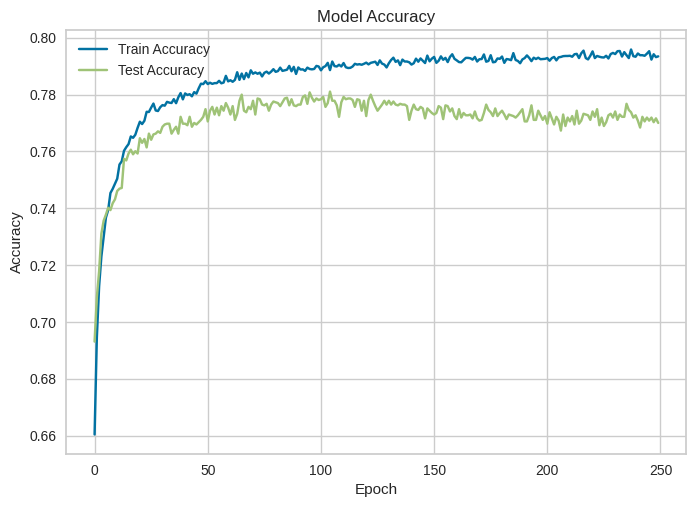

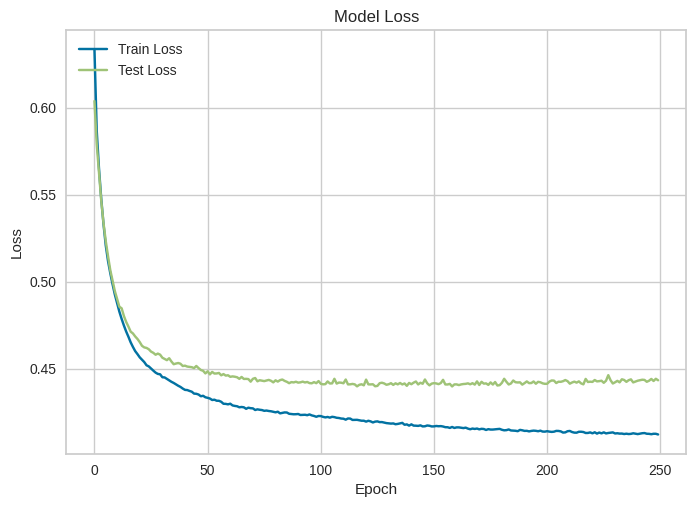

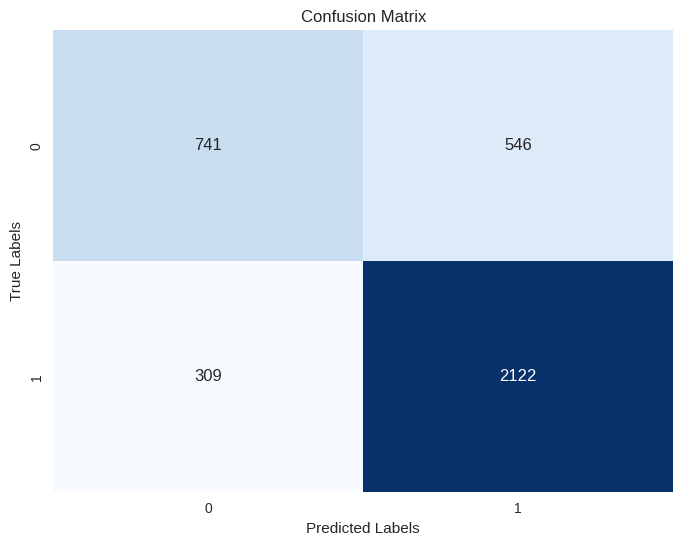

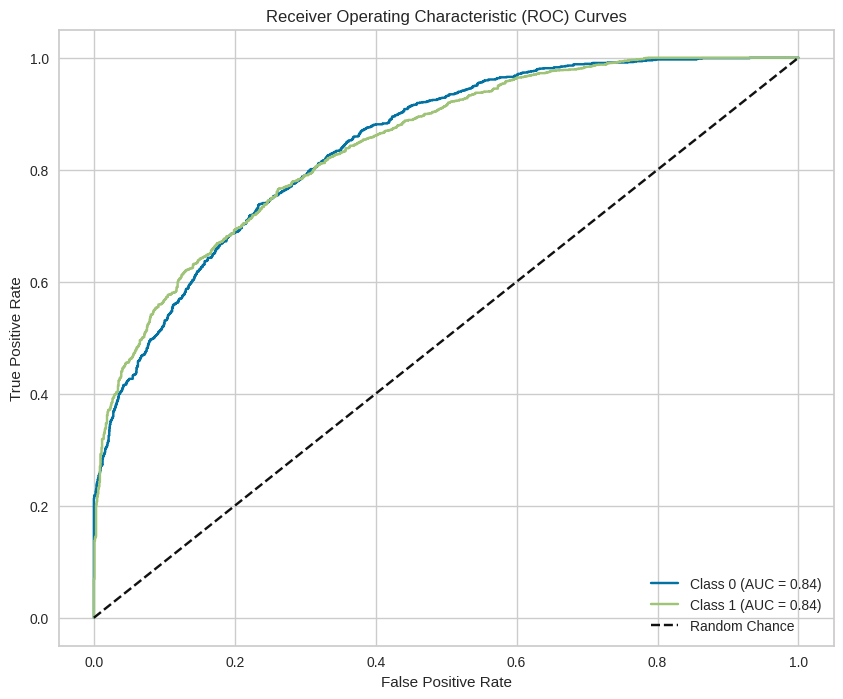

In [ ]:
evaluate_model(model, X_test, y_test, history)

##Red 2: ANN Simple- ELU

In [ ]:
model = Sequential()
model.add(Dense(16, input_dim=12, activation="elu"))
model.add(Dense(12, activation="elu"))
model.add(Dense(2, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = model.fit(X_train, y_train, epochs=250, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.6256 - loss: 0.6532 - val_accuracy: 0.6947 - val_loss: 0.5777
Epoch 2/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6987 - loss: 0.5759 - val_accuracy: 0.7006 - val_loss: 0.5666
Epoch 3/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7070 - loss: 0.5572 - val_accuracy: 0.7041 - val_loss: 0.5594
Epoch 4/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7107 - loss: 0.5541 - val_accuracy: 0.7071 - val_loss: 0.5517
Epoch 5/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7148 - loss: 0.5470 - val_accuracy: 0.7160 - val_loss: 0.5453
Epoch 6/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7164 - loss: 0.5431 - val_accuracy: 0.7152 - val_loss: 0.5386
Epoch 7/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7143 - loss: 0.5376 - val_accuracy: 0.7222 - val_loss: 0.5313
Epoch 8/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7280 - loss: 0.5235 - val_acc

117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 0.7681549220010758
F1 Score: 0.8330751355538342
Recall: 0.8848210612916495


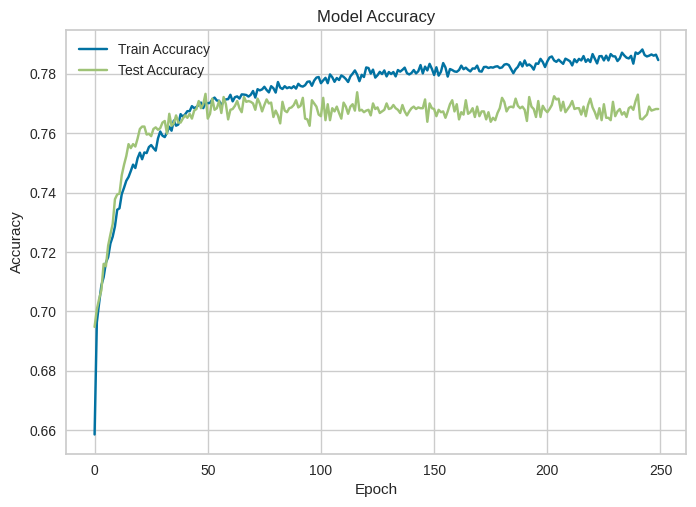

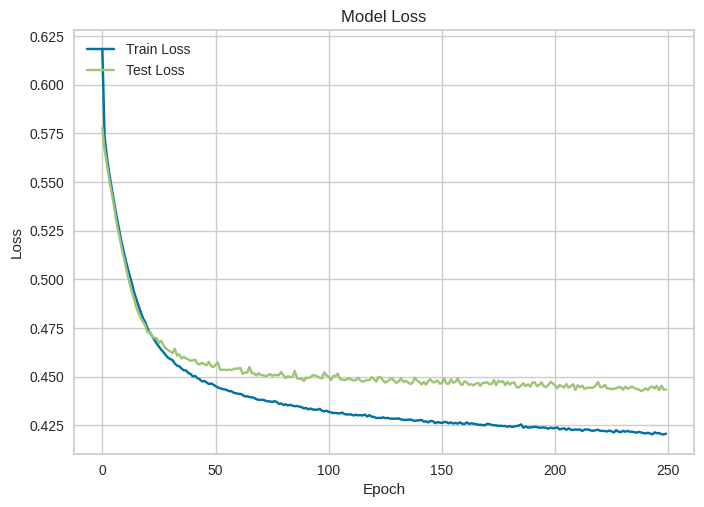

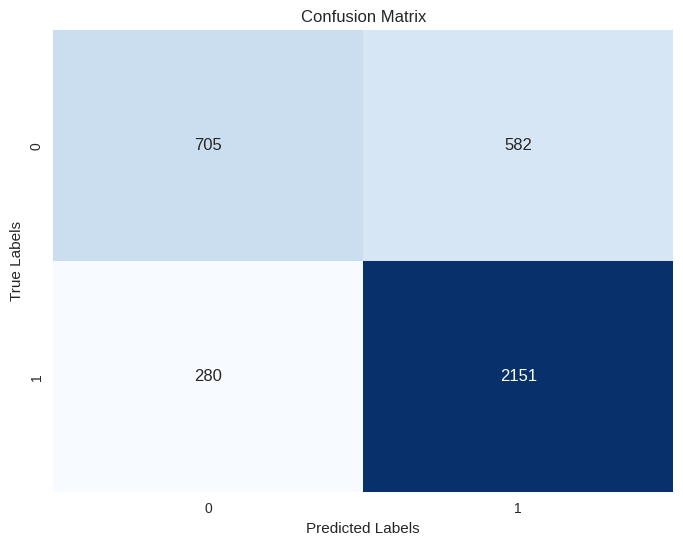

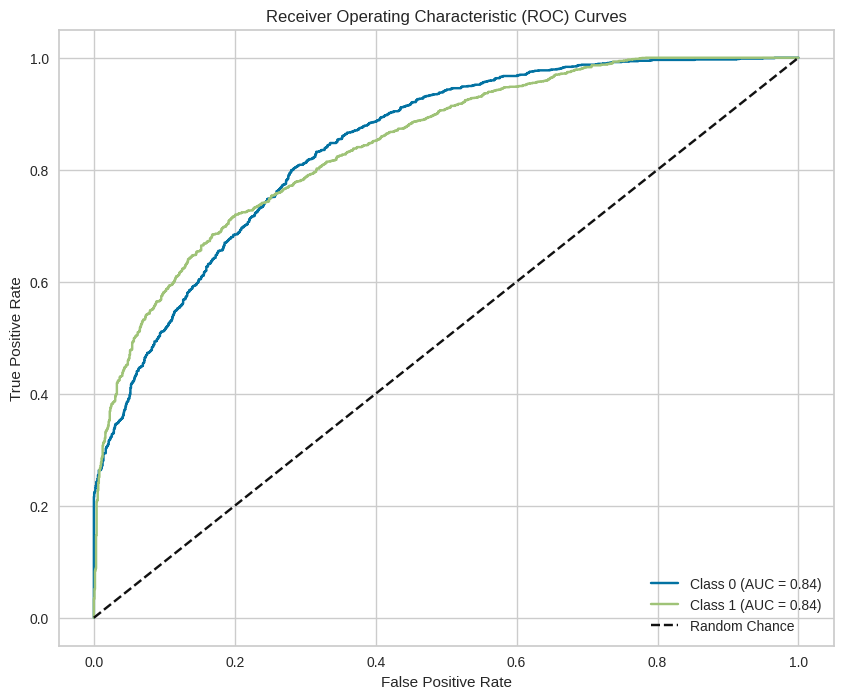

In [ ]:
evaluate_model(model, X_test, y_test, history)

##Red 3: ANN Simple- Selu

In [ ]:
model = Sequential()
model.add(Dense(16, input_dim=12, activation="selu"))
model.add(Dense(12, activation="selu"))
model.add(Dense(2, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = model.fit(X_train, y_train, epochs=250, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.5774 - loss: 0.7600 - val_accuracy: 0.6740 - val_loss: 0.5922
Epoch 2/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6884 - loss: 0.5867 - val_accuracy: 0.6899 - val_loss: 0.5789
Epoch 3/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6973 - loss: 0.5703 - val_accuracy: 0.6998 - val_loss: 0.5718
Epoch 4/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6982 - loss: 0.5689 - val_accuracy: 0.6993 - val_loss: 0.5682
Epoch 5/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7039 - loss: 0.5608 - val_accuracy: 0.7023 - val_loss: 0.5638
Epoch 6/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7193 - loss: 0.5495 - val_accuracy: 0.7036 - val_loss: 0.5603
Epoch 7/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7150 - loss: 0.5508 - val_accuracy: 0.7036 - val_loss: 0.5582
Epoch 8/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7213 - loss: 0.5471 - val_acc

117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 0.7724583109198494
F1 Score: 0.833922261484099
Recall: 0.8737145207733443


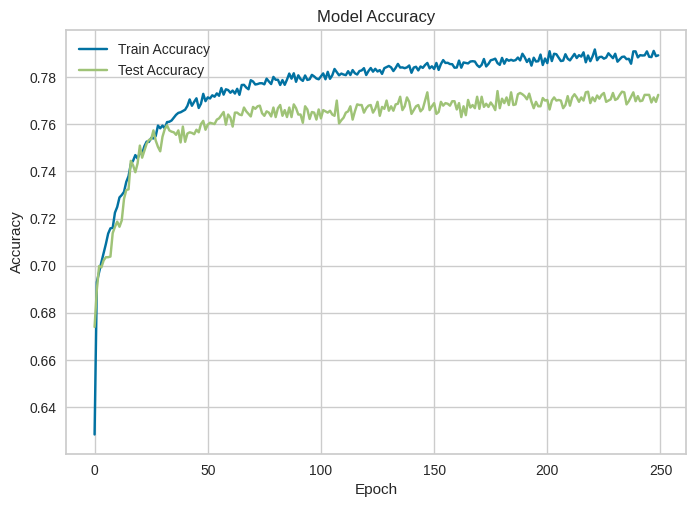

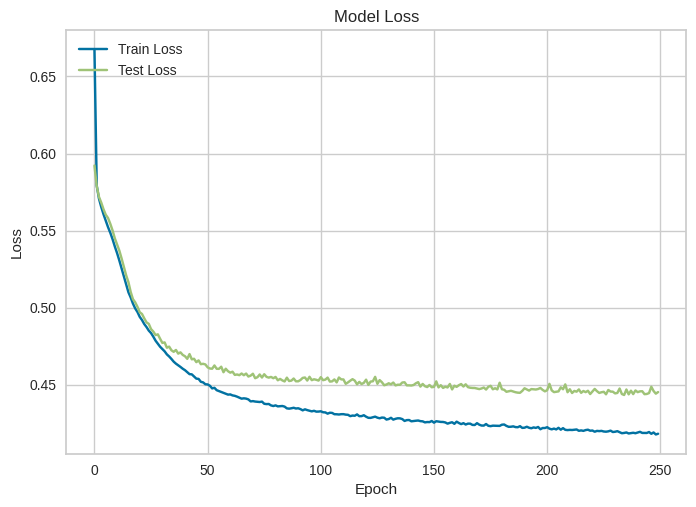

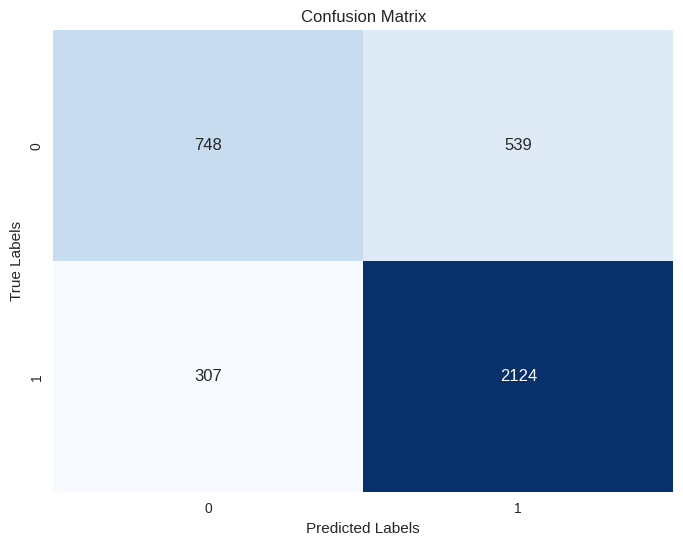

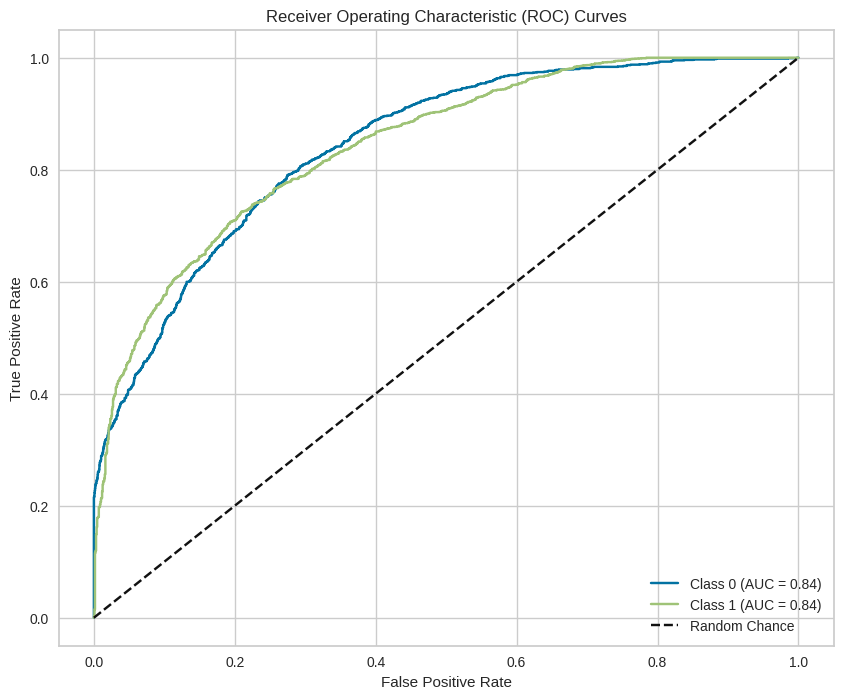

In [ ]:
evaluate_model(model, X_test, y_test, history)

**Dados los resultados anteriores, se evidencian mejores métricas mediante la función de activación SELU, por lo tanto, tomaremos está función como base para los demas hiperparametros**

##Red 4

In [ ]:
model = Sequential()

model.add(Dense(512, input_dim=12, activation="selu"))
model.add(Dropout(0.5))

model.add(Dense(256, activation="selu"))
model.add(Dropout(0.5))

model.add(Dense(128, activation="selu"))
model.add(Dropout(0.5))

model.add(Dense(64, activation="selu"))
model.add(Dropout(0.5))

model.add(Dense(32, activation="selu"))
model.add(Dropout(0.5))

model.add(Dense(16, input_dim=12, activation="selu"))
model.add(Dropout(0.5))

model.add(Dense(12, activation="selu"))


model.add(Dense(2, activation="softmax"))

learning_rate = 0.001
optimizer=Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


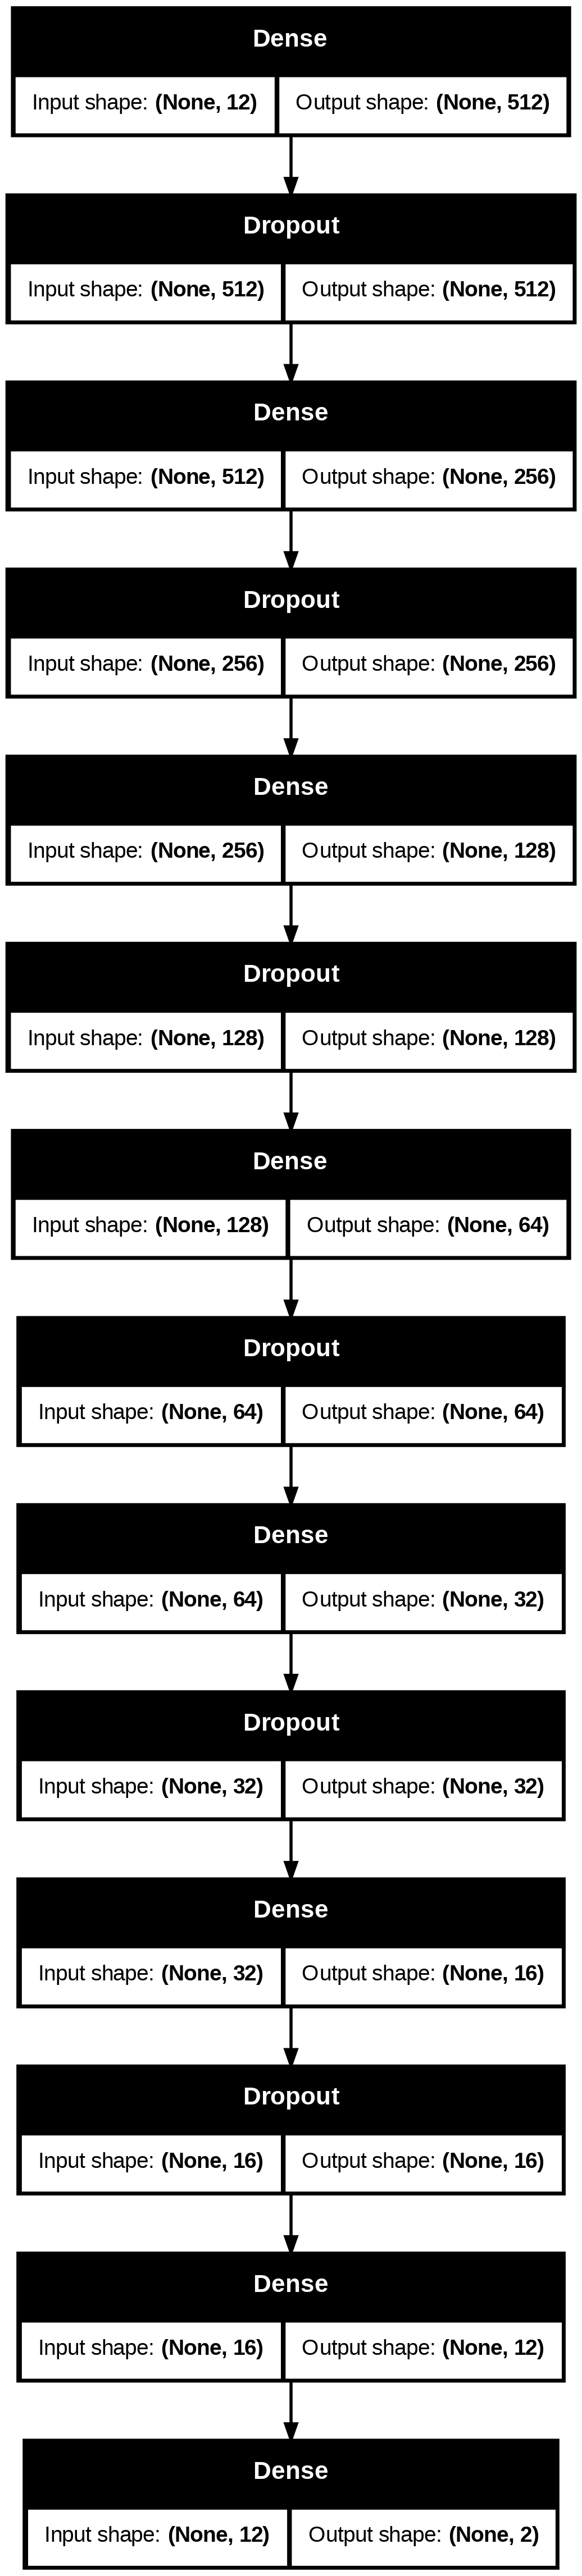

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
history = model.fit(X_train, y_train, epochs=250, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 40s 289ms/step - accuracy: 0.5751 - loss: 1.0659 - val_accuracy: 0.6654 - val_loss: 0.6415
Epoch 2/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6049 - loss: 0.7005 - val_accuracy: 0.6969 - val_loss: 0.5878
Epoch 3/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6480 - loss: 0.6472 - val_accuracy: 0.6982 - val_loss: 0.5714
Epoch 4/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6632 - loss: 0.6225 - val_accuracy: 0.6926 - val_loss: 0.5756
Epoch 5/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6742 - loss: 0.5997 - val_accuracy: 0.6953 - val_loss: 0.5686
Epoch 6/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6780 - loss: 0.5968 - val_accuracy: 0.6942 - val_loss: 0.5714
Epoch 7/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6716 - loss: 0.5971 - val_accuracy: 0.6859 - val_loss: 0.5653
Epoch 8/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6791 - loss: 0.5814 - val_a

117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.7899408284023669
F1 Score: 0.8416142770229162
Recall: 0.853558206499383


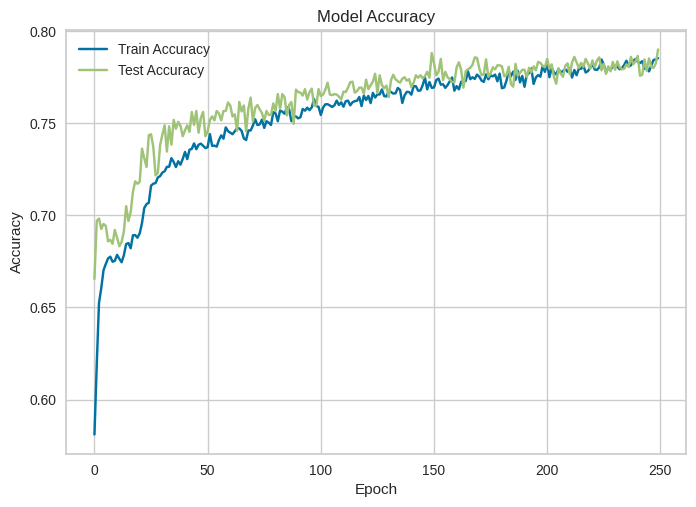

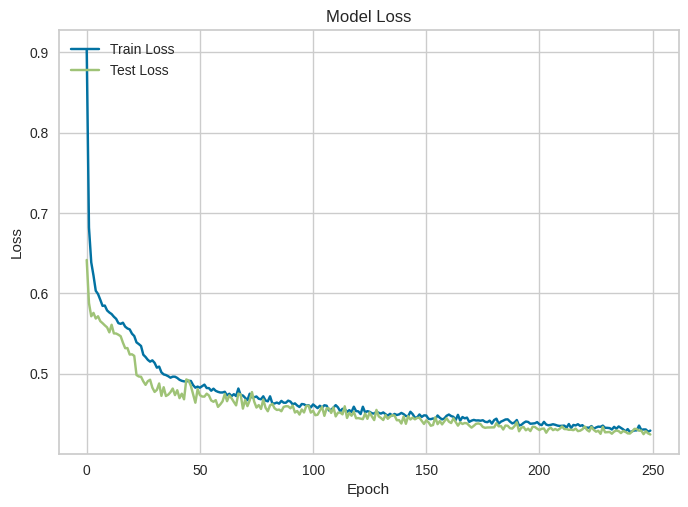

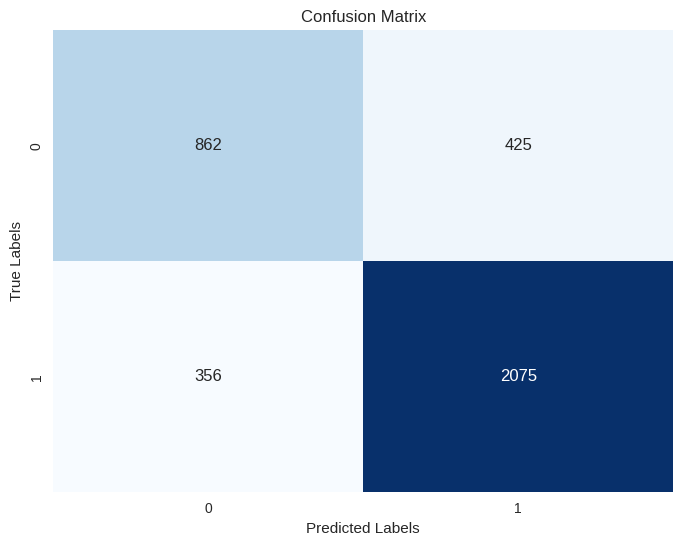

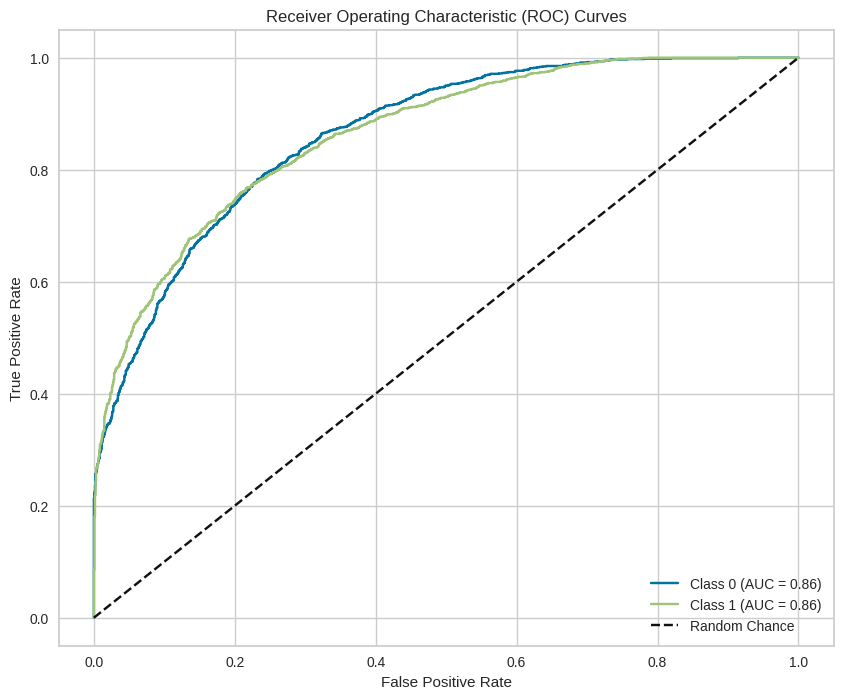

In [ ]:
evaluate_model(model, X_test, y_test, history)

##Red 5

In [ ]:
model = Sequential()

model.add(Dense(512, input_dim=12, activation="selu"))
model.add(Dense(512, activation="selu"))
model.add(Dropout(0.5))

model.add(Dense(256, activation="selu"))
model.add(Dense(256, activation="selu"))
model.add(Dropout(0.5))

model.add(Dense(128, activation="selu"))
model.add(Dense(128, activation="selu"))
model.add(Dropout(0.5))

model.add(Dense(64, activation="selu"))
model.add(Dense(64, activation="selu"))
model.add(Dropout(0.5))

model.add(Dense(32, activation="selu"))
model.add(Dense(32, activation="selu"))
model.add(Dropout(0.5))

model.add(Dense(16, input_dim=12, activation="selu"))
model.add(Dense(16, input_dim=12, activation="selu"))
model.add(Dropout(0.5))

model.add(Dense(12, activation="selu"))
model.add(Dense(12, activation="selu"))



model.add(Dense(2, activation="softmax"))

learning_rate = 0.001
optimizer=Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = model.fit(X_train, y_train, epochs=250, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step - accuracy: 0.5607 - loss: 0.8920 - val_accuracy: 0.6547 - val_loss: 0.6052
Epoch 2/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6384 - loss: 0.6615 - val_accuracy: 0.6692 - val_loss: 0.5970
Epoch 3/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6492 - loss: 0.6300 - val_accuracy: 0.6756 - val_loss: 0.5847
Epoch 4/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6570 - loss: 0.6094 - val_accuracy: 0.6700 - val_loss: 0.5863
Epoch 5/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6587 - loss: 0.6067 - val_accuracy: 0.6409 - val_loss: 0.5854
Epoch 6/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6628 - loss: 0.5898 - val_accuracy: 0.6719 - val_loss: 0.5716
Epoch 7/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6672 - loss: 0.5864 - val_accuracy: 0.6764 - val_loss: 0.5769
Epoch 8/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6663 - loss: 0.5862 - val_ac

117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accuracy: 0.7899408284023669
F1 Score: 0.8473715067422317
Recall: 0.8918140682846565


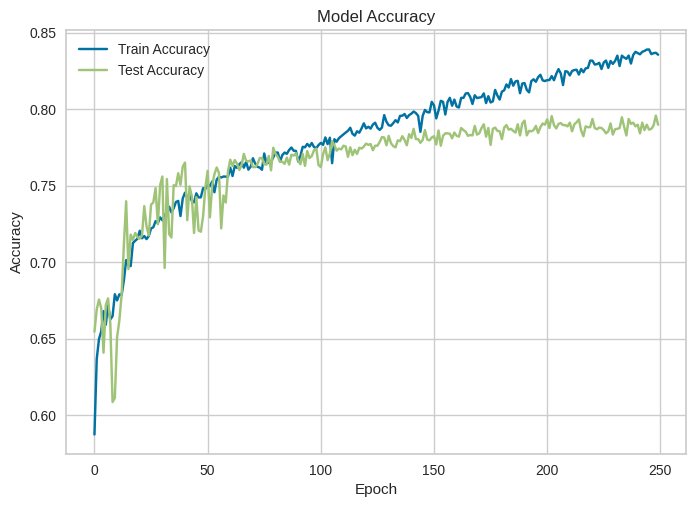

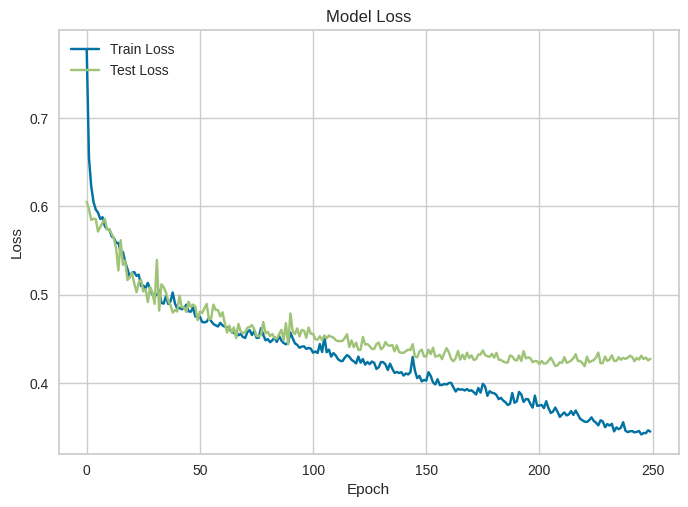

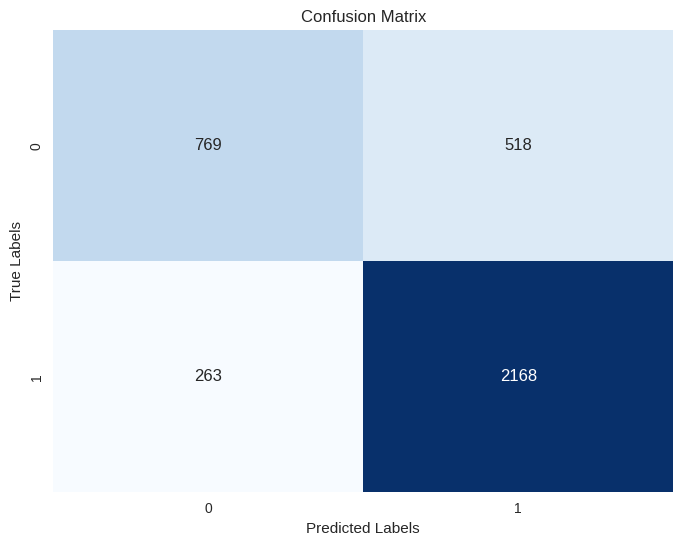

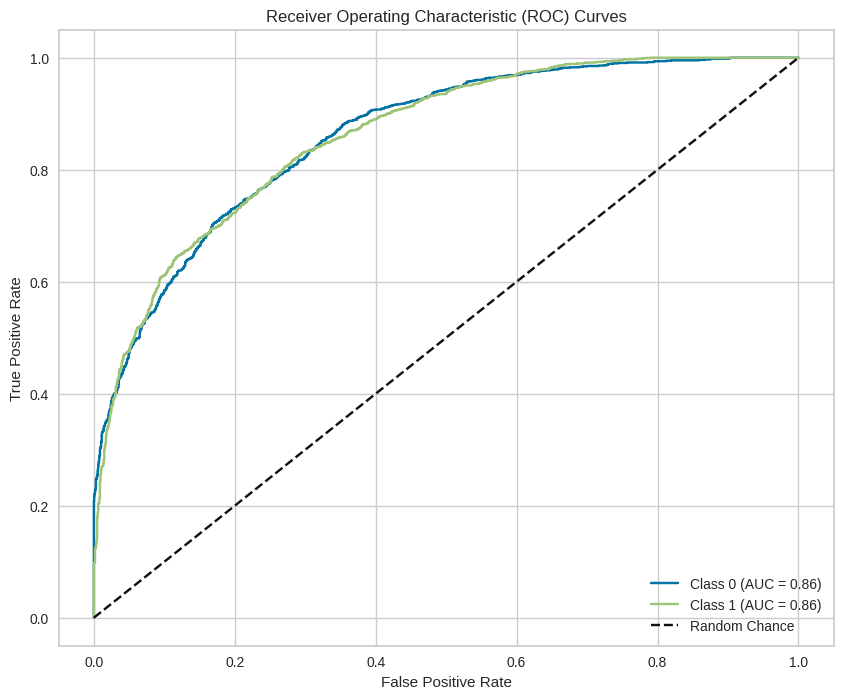

In [ ]:
evaluate_model(model, X_test, y_test, history)

Red 5- Invertida

In [ ]:
model = Sequential()

model.add(Dense(12,input_dim=12, activation="selu"))
model.add(Dropout(0.5))

model.add(Dense(16,activation="selu"))
model.add(Dropout(0.5))

model.add(Dense(32, activation="selu"))
model.add(Dropout(0.5))

model.add(Dense(64, activation="selu"))
model.add(Dropout(0.5))

model.add(Dense(128, activation="selu"))
model.add(Dropout(0.5))

model.add(Dense(256, activation="selu"))
model.add(Dropout(0.5))

model.add(Dense(512, input_dim=12, activation="selu"))


model.add(Dense(2, activation="softmax"))

learning_rate = 0.001
optimizer=Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = model.fit(X_train, y_train, epochs=250, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 41s 288ms/step - accuracy: 0.5629 - loss: 0.9643 - val_accuracy: 0.6686 - val_loss: 0.6388
Epoch 2/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5812 - loss: 0.7524 - val_accuracy: 0.6528 - val_loss: 0.6342
Epoch 3/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6067 - loss: 0.7001 - val_accuracy: 0.6657 - val_loss: 0.6178
Epoch 4/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6229 - loss: 0.6740 - val_accuracy: 0.6810 - val_loss: 0.6065
Epoch 5/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6276 - loss: 0.6637 - val_accuracy: 0.6775 - val_loss: 0.5998
Epoch 6/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6317 - loss: 0.6568 - val_accuracy: 0.6805 - val_loss: 0.5965
Epoch 7/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6464 - loss: 0.6462 - val_accuracy: 0.6931 - val_loss: 0.5852
Epoch 8/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6420 - loss: 0.6389 - val_a

117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Accuracy: 0.7210866057019903
F1 Score: 0.8182296231375986
Recall: 0.9600987248046071


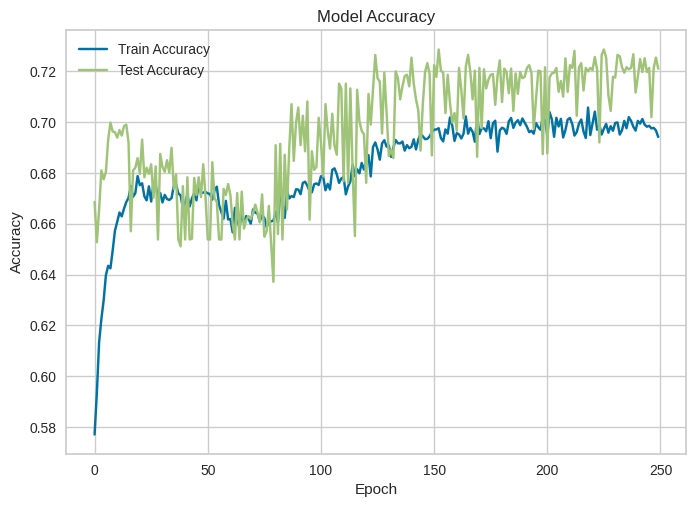

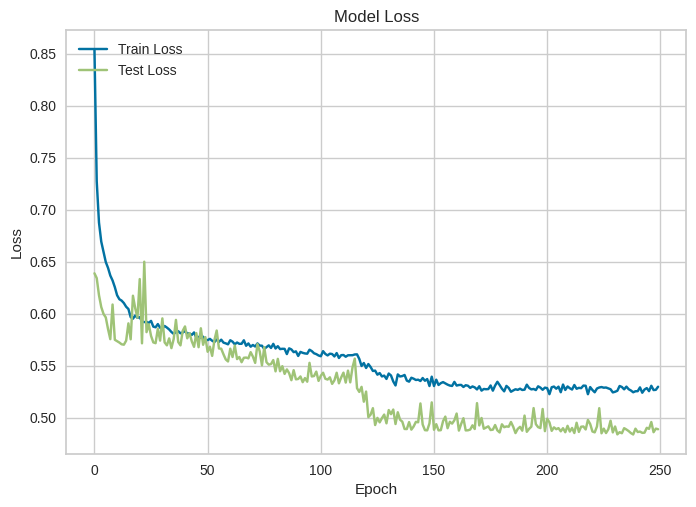

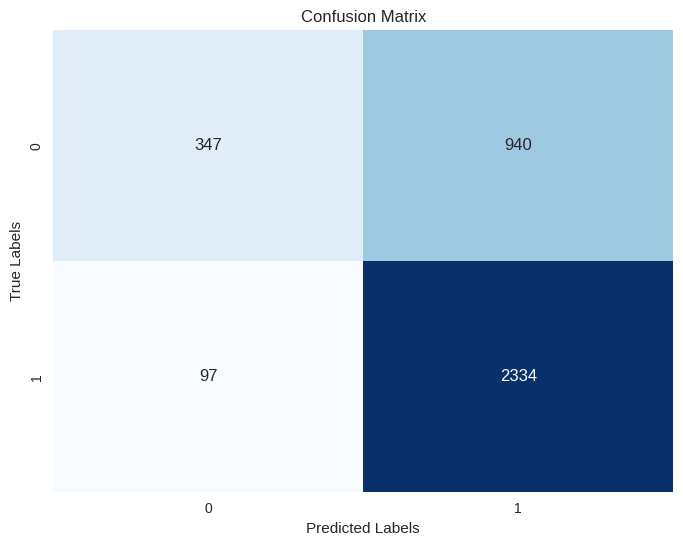

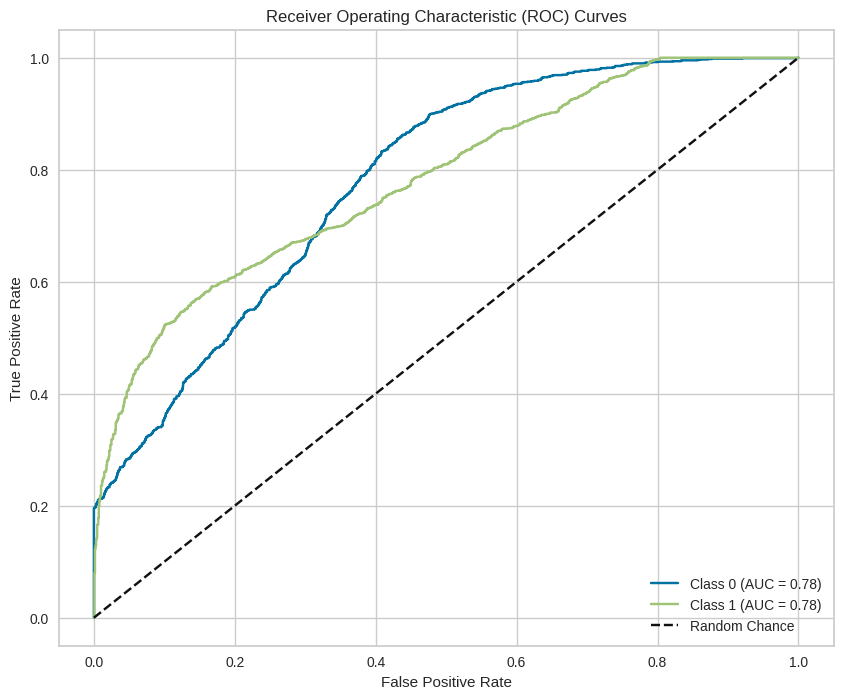

In [ ]:
evaluate_model(model, X_test, y_test, history)

In [ ]:
# Matriz de confusión
confusion_matrix_values = np.array([
    [862, 425],
    [356, 2075]
])

# Calcular la matriz de confusión en porcentaje por filas
conf_matrix_percent = confusion_matrix_values.astype('float') / confusion_matrix_values.sum(axis=1)[:, np.newaxis] * 100

# Mostrar la matriz en porcentajes
print(conf_matrix_percent)

[[66.97746698 33.02253302]
 [14.64417935 85.35582065]]
